In [1]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np

from valleyfloor.process_topography import process_topography
from valleyfloor.utils import setup_wbt

logger.enable("valleyfloor")

In [2]:
wbt = setup_wbt("~/opt/WBT/", "../working_dir")

dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
flowlines = gpd.read_file("../data/input/flowlines.shp")

In [3]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt)
aligned_flowlines = gpd.GeoSeries(aligned_flowlines['geometry'].values, index=aligned_flowlines['Stream_ID'])
aligned_flowlines

2024-10-11 13:14:54.364 | INFO     | valleyfloor.process_topography:process_topography:36 - process topography
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-mqMb1mKH-py3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Stream_ID
1.0     LINESTRING (393865.5 3791235.5, 393866.5 37912...
2.0     LINESTRING (395219.5 3791163.5, 395218.5 37911...
3.0     LINESTRING (394322.5 3791032.5, 394322.5 37910...
4.0     LINESTRING (395096.5 3791023.5, 395096.5 37910...
5.0     LINESTRING (394657.5 3790993.5, 394654.5 37909...
6.0     LINESTRING (394902.5 3790597.5, 394902.5 37905...
7.0     LINESTRING (394514.5 3790355.5, 394514.5 37903...
9.0     LINESTRING (394536.5 3790394.5, 394536.5 37903...
10.0    LINESTRING (394129.5 3790570.5, 394128.5 37905...
11.0    LINESTRING (394631.5 3790957.5, 394630.5 37909...
12.0    LINESTRING (395030.5 3791080.5, 395029.5 37910...
13.0    LINESTRING (394304.5 3790811.5, 394301.5 37908...
14.0    LINESTRING (394144.5 3790721.5, 394143.5 37907...
dtype: geometry

In [5]:
dataset['flowpaths'].rio.to_raster("../working_dir/flowpaths.tif")

In [4]:
from slopes.subbasins import label_subbasins
from slopes.hillslopes import label_hillslopes

In [5]:
subbasins = label_subbasins(dataset['flow_dir'], dataset['flow_acc'], dataset['flowpaths'], wbt)

In [6]:
hillslopes = label_hillslopes(dataset['flowpaths'], dataset['flow_dir'], subbasins, wbt)

In [16]:
dataset['hillslope'] = hillslopes
dataset['subbasins'] = subbasins

In [8]:
from slopes.network_xsections import network_xsections, observe_values

In [43]:
xs = network_xsections(aligned_flowlines, 10, 40, 3, subbasins=subbasins)

In [44]:
xs = observe_values(xs, dataset[['conditioned_dem', 'hand', 'slope', 'curvature', 'hillslope', 'flowpaths']])

In [45]:
xs

,geom,pointID,streamID,xsID,alpha,conditioned_dem,hand,slope,curvature,hillslope,flowpaths
16698,POINT (393697.916 3791067.916),0,1.0,0,-237,962.053223,114.158671,13.505434,0.020138,3.0,NaN
16699,POINT (393700.037 3791070.037),1,1.0,0,-234,960.316589,112.422038,28.941158,0.025338,3.0,NaN
16700,POINT (393702.158 3791072.158),2,1.0,0,-231,958.625793,110.731242,32.505211,0.019083,3.0,NaN
17421,POINT (393704.28 3791074.28),3,1.0,0,-228,956.708313,108.813762,35.937660,0.010088,3.0,NaN
17422,POINT (393706.401 3791076.401),4,1.0,0,-225,954.640503,106.745952,36.074234,-0.003386,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
74380,POINT (394195.88 3790643.471),74786,14.0,17,95,847.804199,48.960571,37.677765,-0.016617,3.0,NaN
74382,POINT (394198.001 3790645.592),74787,14.0,17,98,850.866211,52.022583,42.611908,-0.006895,3.0,NaN
74384,POINT (394200.122 3790647.713),74788,14.0,17,101,853.341064,54.497437,42.102978,0.007257,3.0,NaN
74386,POINT (394202.244 3790649.835),74789,14.0,17,104,855.799316,56.955688,39.175205,0.012809,3.0,NaN


In [68]:
stream_xs = xs.loc[xs['streamID'] == 6]
sample = stream_xs.loc[stream_xs['xsID'] == 9].sort_values('alpha')
mid = sample.loc[np.isfinite(sample['flowpaths']), 'alpha']

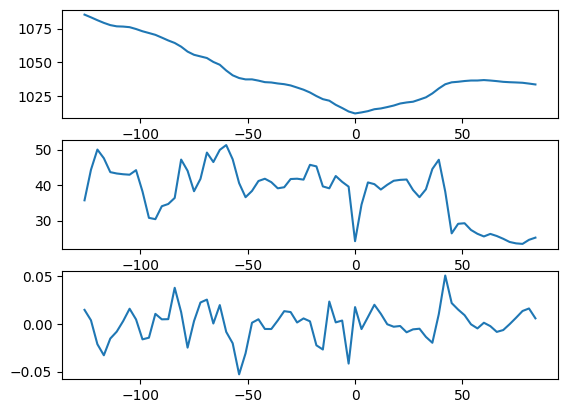

In [69]:
fig, axes = plt.subplots(3)
axes[0].plot(sample['alpha'], sample['conditioned_dem'])
axes[1].plot(sample['alpha'], sample['slope'])
axes[2].plot(sample['alpha'], sample['curvature'])

In [77]:
from slopes.segment_profile import mean_shift

In [78]:
slope = sample['slope']

In [79]:
mean_shift(slope)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [19]:
aligned_flowlines

,Stream_ID,geometry
0,1.0,"LINESTRING (393865.5 3791235.5, 393866.5 37912..."
1,2.0,"LINESTRING (395219.5 3791163.5, 395218.5 37911..."
2,3.0,"LINESTRING (394322.5 3791032.5, 394322.5 37910..."
3,4.0,"LINESTRING (395096.5 3791023.5, 395096.5 37910..."
4,5.0,"LINESTRING (394657.5 3790993.5, 394654.5 37909..."
5,6.0,"LINESTRING (394902.5 3790597.5, 394902.5 37905..."
6,7.0,"LINESTRING (394514.5 3790355.5, 394514.5 37903..."
7,9.0,"LINESTRING (394536.5 3790394.5, 394536.5 37903..."
8,10.0,"LINESTRING (394129.5 3790570.5, 394128.5 37905..."
9,11.0,"LINESTRING (394631.5 3790957.5, 394630.5 37909..."


In [27]:
for idx, val in aligned_flowlines.items():
    print(idx, val)

1.0 LINESTRING (393865.5 3791235.5, 393866.5 3791234.5, 393866.5 3791228.5, 393865.5 3791227.5, 393865.5 3791223.5, 393863.5 3791221.5, 393863.5 3791220.5, 393862.5 3791220.5, 393856.5 3791214.5, 393856.5 3791212.5, 393857.5 3791211.5, 393857.5 3791210.5, 393858.5 3791209.5, 393858.5 3791208.5, 393857.5 3791207.5, 393859.5 3791205.5, 393859.5 3791180.5, 393858.5 3791179.5, 393858.5 3791177.5, 393857.5 3791176.5, 393857.5 3791175.5, 393856.5 3791174.5, 393856.5 3791173.5, 393854.5 3791171.5, 393854.5 3791164.5, 393852.5 3791162.5, 393852.5 3791161.5, 393851.5 3791160.5, 393851.5 3791159.5, 393852.5 3791158.5, 393852.5 3791150.5, 393851.5 3791149.5, 393851.5 3791146.5, 393852.5 3791145.5, 393852.5 3791137.5, 393853.5 3791136.5, 393853.5 3791135.5, 393854.5 3791134.5, 393854.5 3791132.5, 393855.5 3791131.5, 393855.5 3791128.5, 393856.5 3791127.5, 393857.5 3791127.5, 393858.5 3791126.5, 393859.5 3791126.5, 393860.5 3791127.5, 393864.5 3791127.5, 393865.5 3791126.5, 393867.5 3791126.5, 3938